In [1]:
import numpy as np
import pandas as pd
import itertools
import os, stat, time
from os.path import dirname as up
import random
import shutil
import glob
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [2]:
# Plot Settings
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [3]:
from glob import glob
full_data = glob('./Images/**/*.png', recursive=True)
random.shuffle(full_data)
data = full_data[:70000]
del full_data

In [4]:
len(data)

70000

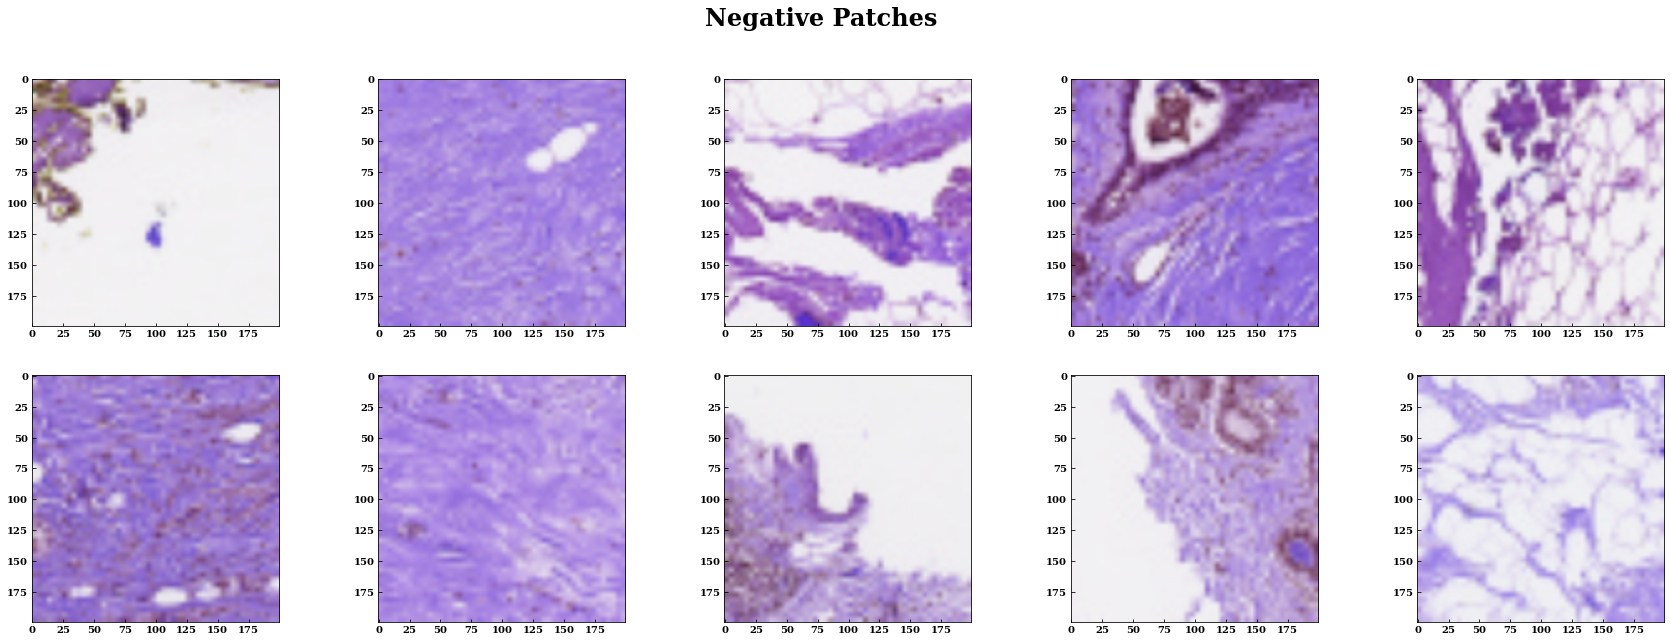

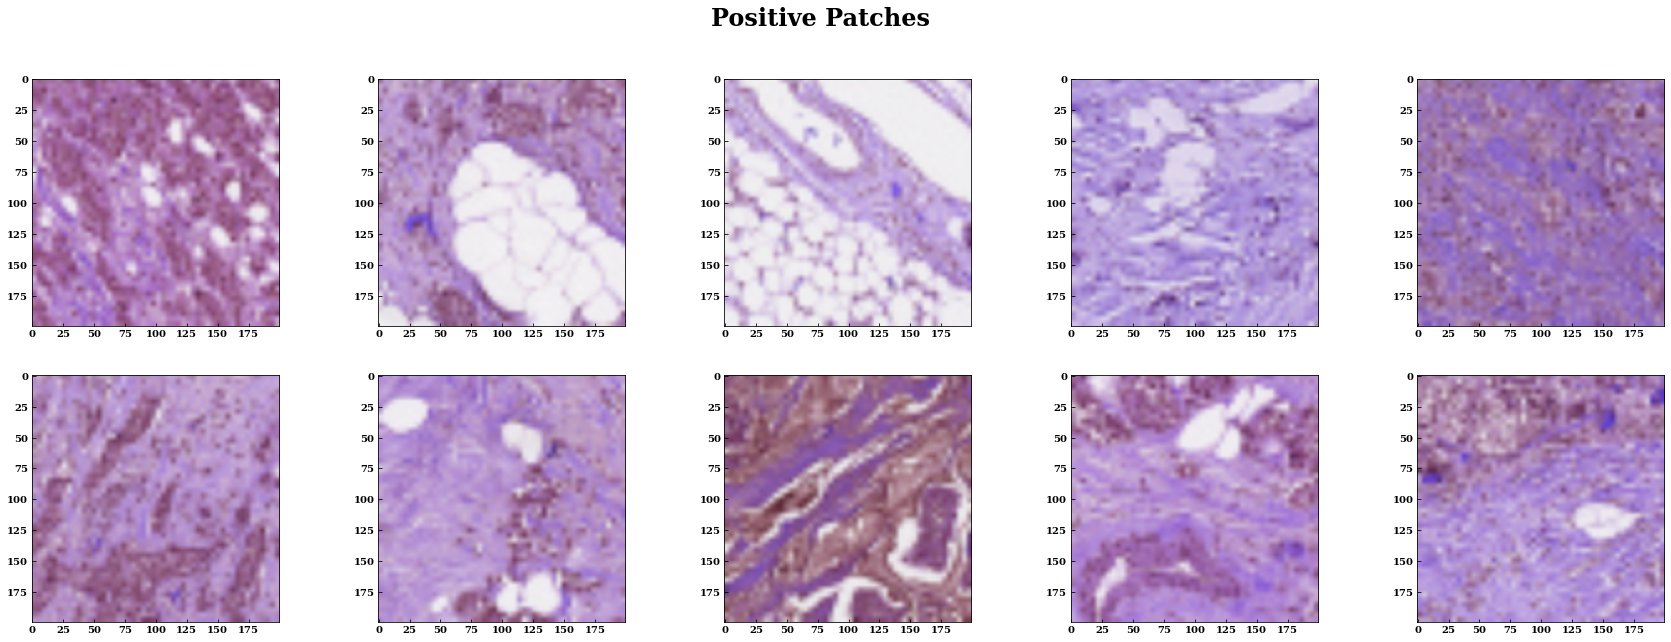

In [5]:
# Negative Patches
fig, ax = plt.subplots(2, 5,figsize = (30,10))

n_plots = 0
for i in data[:1000]:

    if (i[-5]=='0'):
        img = cv2.imread(i)
        img_temp = cv2.resize(img,(200,200))
        ax[n_plots//5, n_plots%5].imshow(img_temp, cmap='binary')
        ax[n_plots//5, n_plots%5].grid(False)
        n_plots += 1
        
    if (n_plots==10): 
        break

fig.suptitle('Negative Patches', fontsize=24, fontweight='bold')
plt.show()

# Positive Patches
fig, ax = plt.subplots(2, 5,figsize = (30,10))

n_plots = 0

for i in data[:2000]:

    if (i[-5]=='1'):
        img = cv2.imread(i)
        img_temp = cv2.resize(img,(200,200))
        ax[n_plots//5, n_plots%5].imshow(img_temp, cmap='binary')
        ax[n_plots//5, n_plots%5].grid(False)
        n_plots += 1
        
    if (n_plots==10): 
        break

fig.suptitle('Positive Patches', fontsize=24, fontweight='bold')
plt.show()

In [6]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [7]:
torch.__version__

'1.9.0+cu111'

In [8]:
# Check is GPU is available, and if so, use it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:
# Load the image data into torch.DataLoader for training use
def data_loader(data, index_low, index_high):
    
    images, labels = [], []
    
    for img_name in data[index_low:index_high]:
        if img_name.endswith('.png'):
            label = img_name[-5]
            img = cv2.imread(img_name)
            img_temp = cv2.resize(img,(224,224))
            images.append(img_temp.astype(np.float32))
            labels.append(int(label))        
    
    data_set = []
    for i in range(len(labels)):
        data_set.append([images[i], labels[i]])
    
    # random.shuffle(data_set) 
    
    print ('    Number of images with label 1:', np.sum(labels))
    
    # train_set, val_set = torch.utils.data.random_split(data_set, [int(len(data_set)*0.8), int(len(data_set)*0.2)], 
    #                                                    generator=torch.Generator().manual_seed(42))
    
    train_set = torch.utils.data.Subset(data_set, range(int(len(data_set)*0.8)))
    val_set = torch.utils.data.Subset(data_set, range(int(len(data_set)*0.8), len(data_set)))

    image_datasets = {
        'train': train_set,
        'validation': val_set
    }
    
    batch_size = 64
    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

    dataloaders = {
        'train': train_dataloader,
        'validation': val_dataloader
    }
    
    return image_datasets, dataloaders

In [10]:
# Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True).to(device)

model.fc = nn.Sequential(
               nn.Linear(512, 2),
#                nn.Linear(64, 2),
               nn.Softmax(dim=1)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=4e-7, betas=(0.9, 0.999), 
                        weight_decay=1e-4, eps=1e-08, amsgrad=False)

In [11]:
# Train the model
def train_model(model, criterion, optimizer, num_epochs=3, num_sets=2, num_perset=2000):
    
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    
    for epoch in range(num_epochs):
            
        print()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 50)    
        
        for i_set in range(num_sets):
        
            print ('  Data {}/{}'.format(i_set+1, num_sets))
            image_datasets, dataloaders = data_loader(data, i_set*num_perset, (i_set+1)*num_perset)

            for phase in ['train', 'validation']:
            
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:

                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(torch.transpose(torch.transpose(inputs, 1, 3), 2, 3))
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    # print (outputs)
                    _, preds = torch.max(outputs, 1)
                    # print ('Outputs:', outputs)
                    # print ('Preds:', preds)
                    # print ('Labels:', labels.data)
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    # print ('Running corrects:', running_corrects)

                epoch_loss = running_loss / len(image_datasets[phase])
                epoch_acc = running_corrects / len(image_datasets[phase])

                if phase == 'train':
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)
                else:
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc)

                print('      {} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                                  epoch_loss,
                                                                  epoch_acc))
                
            del image_datasets, dataloaders
                    
        stats = {'train loss': train_loss,
                 'train accuracy': train_acc,
                 'validation loss': val_loss,
                 'validation accuracy': val_acc}
    
    return model, stats

In [12]:
# Model training
model_trained, stats_trained = train_model(model, criterion, optimizer, num_epochs=40, num_sets=8, num_perset=5000)


Epoch 1/40
--------------------------------------------------
  Data 1/8
    Number of images with label 1: 1435


/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


      train loss: 0.6673, acc: 0.6023
      validation loss: 0.6577, acc: 0.6480
  Data 2/8
    Number of images with label 1: 1381
      train loss: 0.6394, acc: 0.6808
      validation loss: 0.6249, acc: 0.7140
  Data 3/8
    Number of images with label 1: 1411
      train loss: 0.6201, acc: 0.7290
      validation loss: 0.6044, acc: 0.7650
  Data 4/8
    Number of images with label 1: 1408
      train loss: 0.6014, acc: 0.7568
      validation loss: 0.5976, acc: 0.7570
  Data 5/8
    Number of images with label 1: 1410
      train loss: 0.5865, acc: 0.7773
      validation loss: 0.5816, acc: 0.7840
  Data 6/8
    Number of images with label 1: 1398
      train loss: 0.5747, acc: 0.7893
      validation loss: 0.5749, acc: 0.7720
  Data 7/8
    Number of images with label 1: 1419
      train loss: 0.5666, acc: 0.7920
      validation loss: 0.5554, acc: 0.8060
  Data 8/8
    Number of images with label 1: 1388
      train loss: 0.5562, acc: 0.7990
      validation loss: 0.5517, acc: 0.

      train loss: 0.4539, acc: 0.8598
      validation loss: 0.4719, acc: 0.8380
  Data 5/8
    Number of images with label 1: 1410
      train loss: 0.4544, acc: 0.8630
      validation loss: 0.4585, acc: 0.8560
  Data 6/8
    Number of images with label 1: 1398
      train loss: 0.4560, acc: 0.8640
      validation loss: 0.4611, acc: 0.8550
  Data 7/8
    Number of images with label 1: 1419
      validation loss: 0.4504, acc: 0.8660
  Data 8/8
    Number of images with label 1: 1388
      train loss: 0.4546, acc: 0.8623
      validation loss: 0.4518, acc: 0.8650

Epoch 9/40
--------------------------------------------------
  Data 1/8
    Number of images with label 1: 1435
      train loss: 0.4486, acc: 0.8700
      validation loss: 0.4595, acc: 0.8570
  Data 2/8
    Number of images with label 1: 1381
      train loss: 0.4516, acc: 0.8638
      validation loss: 0.4593, acc: 0.8540
  Data 3/8
    Number of images with label 1: 1411
      train loss: 0.4479, acc: 0.8680
      validat

    Number of images with label 1: 1388
      train loss: 0.4314, acc: 0.8805
      validation loss: 0.4355, acc: 0.8760

Epoch 16/40
--------------------------------------------------
  Data 1/8
    Number of images with label 1: 1435
      train loss: 0.4304, acc: 0.8878
      validation loss: 0.4417, acc: 0.8610
  Data 2/8
    Number of images with label 1: 1381
      train loss: 0.4352, acc: 0.8785
      validation loss: 0.4432, acc: 0.8640
  Data 3/8
    Number of images with label 1: 1411
      train loss: 0.4309, acc: 0.8840
      validation loss: 0.4288, acc: 0.8860
  Data 4/8
    Number of images with label 1: 1408
      train loss: 0.4306, acc: 0.8815
      validation loss: 0.4536, acc: 0.8560
  Data 5/8
    Number of images with label 1: 1410
      train loss: 0.4365, acc: 0.8758
      validation loss: 0.4401, acc: 0.8720
  Data 6/8
    Number of images with label 1: 1398
      train loss: 0.4357, acc: 0.8763
      validation loss: 0.4427, acc: 0.8690
  Data 7/8
    Number o

    Number of images with label 1: 1411
      train loss: 0.4237, acc: 0.8890
      validation loss: 0.4256, acc: 0.8840
  Data 4/8
    Number of images with label 1: 1408
      train loss: 0.4223, acc: 0.8910
      validation loss: 0.4497, acc: 0.8550
  Data 5/8
    Number of images with label 1: 1410
      train loss: 0.4297, acc: 0.8810
      validation loss: 0.4334, acc: 0.8810
  Data 6/8
    Number of images with label 1: 1398
      train loss: 0.4258, acc: 0.8833
      validation loss: 0.4365, acc: 0.8690
  Data 7/8
    Number of images with label 1: 1419
      train loss: 0.4261, acc: 0.8875
      validation loss: 0.4325, acc: 0.8760
  Data 8/8
    Number of images with label 1: 1388
      train loss: 0.4184, acc: 0.8968
      validation loss: 0.4287, acc: 0.8840

Epoch 24/40
--------------------------------------------------
  Data 1/8
    Number of images with label 1: 1435
      train loss: 0.4205, acc: 0.8948
      validation loss: 0.4336, acc: 0.8700
  Data 2/8
    Number o

    Number of images with label 1: 1398
      train loss: 0.4189, acc: 0.8913
      validation loss: 0.4321, acc: 0.8770
  Data 7/8
    Number of images with label 1: 1419
      train loss: 0.4208, acc: 0.8878
      validation loss: 0.4290, acc: 0.8790
  Data 8/8
    Number of images with label 1: 1388
      train loss: 0.4142, acc: 0.9000
      validation loss: 0.4240, acc: 0.8870

Epoch 31/40
--------------------------------------------------
  Data 1/8
    Number of images with label 1: 1435
      train loss: 0.4149, acc: 0.8963
      validation loss: 0.4292, acc: 0.8800
  Data 2/8
    Number of images with label 1: 1381
      train loss: 0.4179, acc: 0.8963
      validation loss: 0.4360, acc: 0.8740
  Data 3/8
    Number of images with label 1: 1411
      train loss: 0.4162, acc: 0.8985
      validation loss: 0.4231, acc: 0.8870
  Data 4/8
    Number of images with label 1: 1408
      train loss: 0.4099, acc: 0.9033
      validation loss: 0.4442, acc: 0.8560
  Data 5/8
    Number o

    Number of images with label 1: 1435
      train loss: 0.4075, acc: 0.9095
      validation loss: 0.4266, acc: 0.8850
  Data 2/8
    Number of images with label 1: 1381
      train loss: 0.4105, acc: 0.9040
      validation loss: 0.4345, acc: 0.8700
  Data 3/8
    Number of images with label 1: 1411
      train loss: 0.4076, acc: 0.9073
      validation loss: 0.4215, acc: 0.8880
  Data 4/8
    Number of images with label 1: 1408
      train loss: 0.4051, acc: 0.9113
      validation loss: 0.4399, acc: 0.8650
  Data 5/8
    Number of images with label 1: 1410
      train loss: 0.4162, acc: 0.8965
      validation loss: 0.4252, acc: 0.8910
  Data 6/8
    Number of images with label 1: 1398
      train loss: 0.4119, acc: 0.8985
      validation loss: 0.4281, acc: 0.8780
  Data 7/8
    Number of images with label 1: 1419
      train loss: 0.4126, acc: 0.8993
      validation loss: 0.4268, acc: 0.8830
  Data 8/8
    Number of images with label 1: 1388
      train loss: 0.4065, acc: 0.907

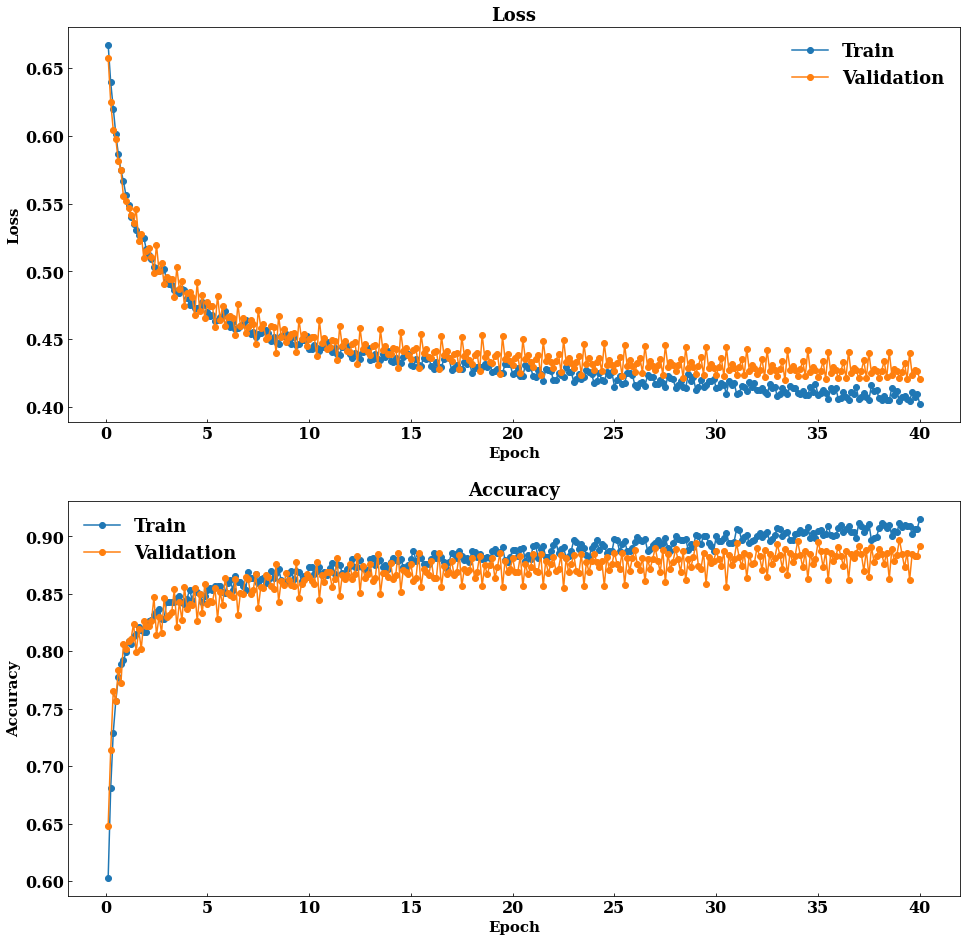

In [13]:
# Visualize training loss and train / val accuracy
fig = plt.figure(figsize=(16,16))
plt.subplot(2, 1, 1)
plt.title('Loss', fontweight='bold', fontsize=18)
plt.plot(np.linspace(0.125,40,320), stats_trained['train loss'], '-o', label='Train')
plt.plot(np.linspace(0.125,40,320), stats_trained['validation loss'], '-o', label='Validation')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best', prop={'size':18}, frameon=False)

plt.subplot(2, 1, 2)
plt.title('Accuracy', fontweight='bold', fontsize=18)
plt.plot(np.linspace(0.125,40,320), stats_trained['train accuracy'], '-o', label='Train')
plt.plot(np.linspace(0.125,40,320), stats_trained['validation accuracy'], '-o', label='Validation')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best', prop={'size':18}, frameon=False)
# plt.gcf().set_size_inches(15, 12)
plt.savefig('./Fig/ResNet18_result_v5.png')
plt.show()

In [27]:
# Use a test dataset to examine the accuracy
test_set, test_loader = data_loader(data, 50000, 60000)
test_dataloader = torch.utils.data.DataLoader(test_set['train'], batch_size=64, shuffle=True)

running_corrects = 0
for inputs, labels in test_dataloader:
    
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model_trained(torch.transpose(torch.transpose(inputs, 1, 3), 2, 3))
    # print (outputs)
    
    _, preds = torch.max(outputs, 1)
    # print ('Predictions:', preds)
    running_corrects += torch.sum(preds == labels.data)
    
print ('Test Accuracy:', running_corrects/len(test_set['train']))

    Number of images with label 1: 2878
Test Accuracy: tensor(0.8884, device='cuda:0')
